<a href="https://colab.research.google.com/github/aisha-partha/AIMLOps-MiniProjects/blob/mp_7/M5_NB_MiniProject_2_Keywords_Extraction_Transformer_G4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Keywords Extraction using Transformer

## Learning Objectives

At the end of the experiment, you will be able to :

* perform data preprocessing, EDA and feature extraction on the Medical Transcription dataset
* build transformer components - positional embedding, encoder, decoder, etc
* train a transformer model for keywords extraction
* create function to perform inference using trained transformer
* use the gradio library  to generate a customizable UI for displaying the extracted keywords

## Dataset description

The dataset used in this project is the **Medical transcription** dataset. It contains sample medical transcriptions for various medical specialties.

The data is in CSV format with below features:

- **description**

- **medical_specialty**

- **sample_name**

- **transcription**

- **keywords**

##  Grading = 10 Points

## Information

Medical transcriptions are textual records of patient-doctor interactions, medical procedures, clinical findings, and more. Extracting keywords from these transcriptions can provide valuable insights into a patient's health status, medical history, and treatment plans.

* Significance:

  - Data Summarization: Keyword extraction helps in summarizing lengthy medical transcriptions, making it easier for healthcare professionals to quickly understand the patient's medical history.

  - Search and Retrieval: Extracted keywords can be used to index medical records, facilitating faster search and retrieval of relevant documents.

  - Trend Analysis: By analyzing frequently occurring keywords, healthcare institutions can identify common ailments, treatment outcomes, and more.

* Applications:

  - Clinical Decision Support: Extracted keywords can be used to develop clinical decision support systems that provide real-time suggestions to healthcare professionals.
  - Patient Monitoring: By continuously analyzing the keywords from a patient's medical transcriptions, healthcare systems can monitor the patient's health and predict potential health risks.
  - Research: Medical researchers can use extracted keywords to identify trends, study disease outbreaks, and understand treatment efficacies.
  - Billing and Insurance: Keywords can help in automating the medical coding process, which is essential for billing and insurance claims.

### Problem Statement

Build a transformer model for performing keywords extraction on medical transcription dataset.

**Note:**
> For some steps such as how to create a positional embedding layer, transformer components - encoder and decoder blocks, etc you may need to refer to the ***M5 Assignment-5 on Transformer_Decoder*** covered in the 25 Aug Tutorial.

### Import required packages

In [1]:
import numpy as np
import pandas as pd
import re
import random
import string
from string import digits
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/Medical_transcription_dataset.csv
!ls | grep ".csv"

Medical_transcription_dataset.csv


**Exercise 1: Read the Medical_transcription_dataset.csv dataset**

**Hint:** pd.read_csv()

In [98]:
# Load the dataset
df = pd.read_csv('Medical_transcription_dataset.csv')
df.head(2)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tr...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."


In [99]:
print(f"No. of records: {df.shape[0]}")

No. of records: 4999


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


### Pre-processing and EDA

**Exercise 2: Perform below operations on the dataset [0.5 Mark]**

- Remove unnecessary columns - 'Unnamed: 0'
- Handle missing values
- Remove rows from data where `keywords` is only single empty space ' $ $ '
- Remove duplicates from data considering `transcription` and `keywords` columns


- **Remove unnecessary columns - 'Unnamed: 0'**

In [101]:
# df = df.iloc[:, 1:]
df.drop([col for col in df.columns if col == 'Unnamed: 0'], axis=1, inplace=True)
df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tr...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."


- **Handle missing values**

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [103]:
df_with_na = df[df.isnull().any(axis=1)]
df_with_na.shape

(1101, 5)

In [104]:
df_with_na.head(5)

,description,medical_specialty,sample_name,transcription,keywords
12,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a ""flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she w...",NaN
24,Blood in urine - Transitional cell cancer of the bladder.,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,",NaN
31,"This is a 66-year-old male with signs and symptoms of benign prostatic hypertrophy, who has had recurrent urinary retention since his kidney transplant. He passed his fill and pull study and was...",Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY OF PRESENT ILLNESS: , This is a 66-year-old gentleman status post deceased donor kidney transplant in 12/07, who has had recurrent urinary retention i...",NaN
32,Right distal ureteral calculus. The patient had hematuria and a CT urogram showing a 1 cm non-obstructing calcification in the right distal ureter. He had a KUB also showing a teardrop shaped c...,Urology,Ureteral Calculus - Consult,"CHIEF COMPLAINT: , Right distal ureteral calculus.,HISTORY OF PRESENT ILLNESS: ,The patient had hematuria and a CT urogram at ABC Radiology on 01/04/07 showing a 1 cm non-obstructing calcificatio...",NaN
39,The patient has a possibly torsion detorsion versus other acute testicular problem.,Urology,Testicular Pain,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF PRESENT ILLNESS:, The patient is a 4-year-old boy with a history of abrupt onset of left testicular pain at 11:30 this morning. He was unable to wa...",NaN


In [105]:
df[df['transcription'].isnull()].head(5)

,description,medical_specialty,sample_name,transcription,keywords
97,Inguinal orchiopexy procedure.,Urology,Inguinal orchiopexy,NaN,"urology, inguinal orchiopexy, keith needles, aponeurosis, bolster, catgut, dartos pouch, external oblique, hernia sac, inguinal ring, orchiopexy, scrotal wall, spermatic cord, spermatic vessels, t..."
116,Inguinal hernia hydrocele repair.,Urology,Hydrocele Repair,NaN,"urology, inguinal hernia, external oblique, hernia sac, hydrocele, hydrocele repair, ilioinguinal nerve, inguinal skin crease, oblique aponeurosis, scrotum, spermatic cord, testicle appendix, tran..."
205,Vaginal Hysterectomy. A weighted speculum was placed in the posterior vaginal vault. The cervix was grasped with a Massachusetts clamp on both its anterior and posterior lips.,Surgery,Vaginal Hysterectomy,NaN,"surgery, omentum, massachusetts, vaginal hysterectomy, vaginal vault, vaginal mucosa, vicryl suture, hysterectomy, ligaments, speculum, ligated, vaginal, sutureNOTE,: Thesetranscribed medical tran..."
263,"Total Abdominal Hysterectomy (TAH). An incision was made into the abdomen down through the subcutaneous tissue, muscular fascia and peritoneum. Once inside the abdominal cavity, a self-retainin...",Surgery,Total Abdominal Hysterectomy,NaN,"surgery, fundus, double-toothed tenaculum, muscular fascia, total abdominal hysterectomy, vicryl suture, abdominal, incision, hysterectomy, uterine, cavity, uterus, ligaments, peritoneum, vicrylNO..."
459,Parotidectomy procedure,Surgery,Parotidectomy,NaN,"surgery, parotidectomy, mixter clamp, auditory canal, buccal, buccinator, curved clamp, earlobe, fascia, fat layer, frontotemporal, mandibular, mastoid process, parotid, parotid duct, parotid glan..."


In [106]:
# Drop missing values
df = df.dropna()
df.shape

(3898, 5)

- **Remove rows from data where `keywords` is only single empty space ' '**

In [107]:
# Count of rows where keywords are ' '
print(f"Count of rows where keywords are ' ': {df[df['keywords']==' '].shape[0]}")

Count of rows where keywords are ' ': 81


In [108]:
# Remove rows where keywords are ' '
df = df[df['keywords']!=' ']
print(f"No. of records remaining: {df.shape[0]}")

No. of records remaining: 3817


- **Remove duplicates from data considering `transcription` and `keywords` columns**

In [109]:
# Check duplicates
df.duplicated(subset=['transcription', 'keywords']).value_counts()

,count
False,3817


In [110]:
df = df.drop_duplicates(subset=['transcription', 'keywords'])
df.shape

(3817, 5)

**Exercise 3: Display  all the categories of `medical_specialty` and their counts in the dataset [0.5 Mark]**



In [111]:
# Displaying the distinct categories of medical specialty
print(f"List of distinct categories of medical specialty: \n\n {df['medical_specialty'].unique()}")

List of distinct categories of medical specialty: 

 [' Allergy / Immunology' ' Bariatrics' ' Cardiovascular / Pulmonary'
 ' Dentistry' ' Urology' ' General Medicine' ' Surgery'
 ' Speech - Language' ' SOAP / Chart / Progress Notes' ' Sleep Medicine'
 ' Rheumatology' ' Radiology' ' Psychiatry / Psychology' ' Podiatry'
 ' Physical Medicine - Rehab' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Office Notes' ' Obstetrics / Gynecology'
 ' Neurosurgery' ' Neurology' ' Nephrology' ' Letters'
 ' Lab Medicine - Pathology' ' IME-QME-Work Comp etc.'
 ' Hospice - Palliative Care' ' Hematology - Oncology' ' Gastroenterology'
 ' ENT - Otolaryngology' ' Endocrinology' ' Emergency Room Reports'
 ' Discharge Summary' ' Diets and Nutritions' ' Dermatology'
 ' Cosmetic / Plastic Surgery' ' Consult - History and Phy.'
 ' Chiropractic']


In [112]:
# Total categories
print(f"No. of unique categories of medical specialities: {df['medical_specialty'].nunique()}")

No. of unique categories of medical specialities: 39


In [113]:
# Displaying the distinct categories of medical specialty and the number of records belonging to each category
df.groupby(['medical_specialty'], as_index=False).size().sort_values(by='size', ascending=False).reset_index(drop=True)

,medical_specialty,size
0,Surgery,1008
1,Orthopedic,296
2,Cardiovascular / Pulmonary,276
3,Radiology,248
4,Consult - History and Phy.,220
5,Gastroenterology,193
6,Neurology,162
7,SOAP / Chart / Progress Notes,140
8,Urology,139
9,General Medicine,137


**Exercise 4: Create a pie plot depicting the percentage of `medical_specialty` distributions category-wise. [0.5 mark]**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

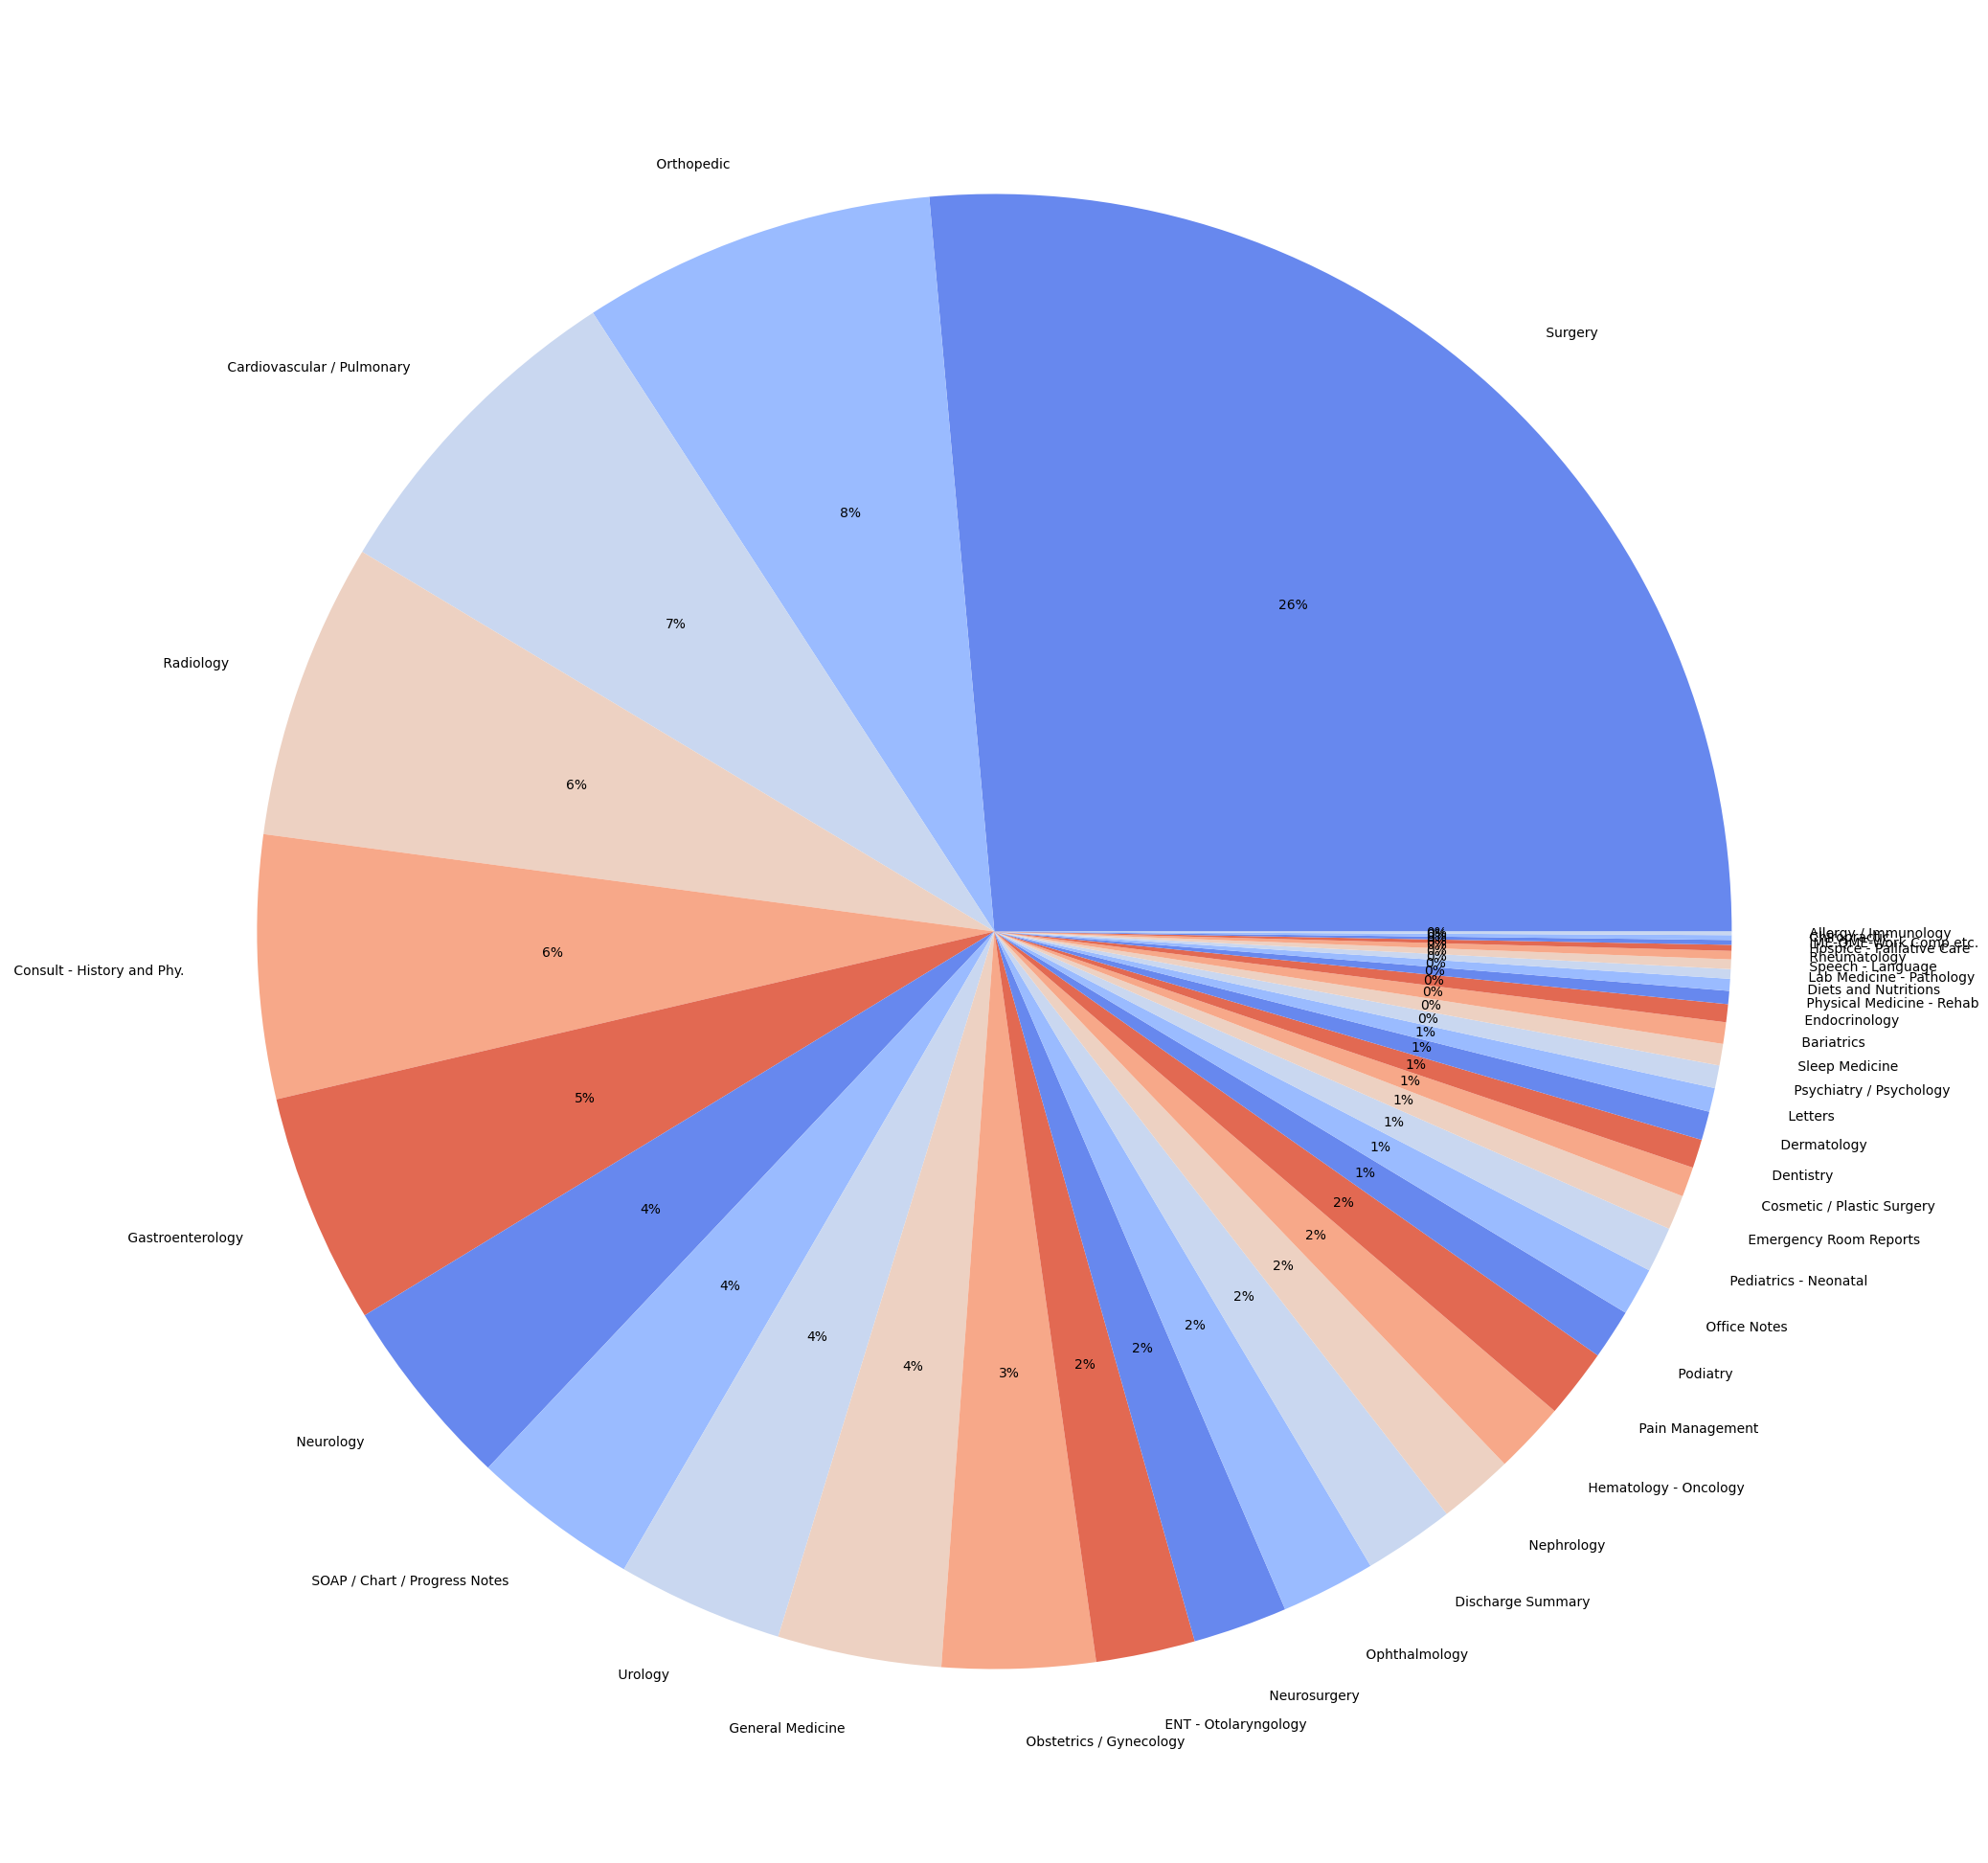

In [114]:
targetCounts = df['medical_specialty'].value_counts()
targetLabels  = targetCounts.index

plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)

palette_color = sns.color_palette('coolwarm')

plt.pie(targetCounts, labels=targetLabels, colors=palette_color, autopct='%.0f%%')

plt.show()

### Pre-process `transcription` and `keywords` text

**Exercise 5: Create functions to perform below tasks: [0.5 Mark]**

- Convert transcription and keywords text to lowercase
- Remove quotes from transcription and keywords text
- Remove all the special characters/punctuations
- Remove digits from transcription and keywords text
- Remove extra spaces

- **Convert `transcription` and `keywords` text to lowercase**

In [115]:
# Convert transcription and keywords text to lowercase
def makelower(df, cols):

    for col in cols:
        df[col] = df[col].str.lower()

    return df

df = makelower(df, ['transcription', 'keywords'])
df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female presents with complaint of allergies. she used to have allergies when she lived in seattle but she thinks they are worse here. in the past, she has tr...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. he exercises three times a week at...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."


- **Remove quotes from `transcription` and `keywords` text**

In [116]:
# Remove quotes from transcription and keywords text
def remquote(df, cols):

    for col in cols:
        df[col] = df[col].str.replace('"', '')

    return df
    # medtext = re.sub(r'"', '', medtext)
    # return medtext

df=remquote(df, ['transcription', 'keywords'])
df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female presents with complaint of allergies. she used to have allergies when she lived in seattle but she thinks they are worse here. in the past, she has tr...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. he exercises three times a week at...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."


- **Remove punctuations**

In [117]:
# Remove punctuations
import re
import string

def rempunct(medtext):

    medtext = re.sub(f"[{re.escape(string.punctuation)}]", '', medtext)

    return medtext

cols = ['transcription', 'keywords']
for col in cols:

    df[col] = df[col].apply(lambda x: rempunct(x))

df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,subjective this 23yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried cla...,allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home a...,bariatrics laparoscopic gastric bypass weight loss programs gastric bypass atkins diet weight watchers body weight laparoscopic gastric weight loss pounds months weight laparoscopic band loss diet...


- **Remove digits from `transcription` and `keywords` text**

In [118]:
# Remove digits from transcription and keywords sentences
def remdigit(medtext):

    medtext = re.sub(r'[0-9]', '', medtext)

    return medtext


cols = ['transcription', 'keywords']
for col in cols:

    df[col] = df[col].apply(lambda x: remdigit(x))

df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried clari...,allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home a...,bariatrics laparoscopic gastric bypass weight loss programs gastric bypass atkins diet weight watchers body weight laparoscopic gastric weight loss pounds months weight laparoscopic band loss diet...


- **Remove extra spaces**

In [119]:
# Remove extra spaces
def remspace(medtext):

    medtext = re.sub(r'\s+', ' ', medtext).strip()

    return medtext


cols = ['transcription', 'keywords']
for col in cols:

    df[col] = df[col].apply(lambda x: remspace(x))

df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin...,allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home an...,bariatrics laparoscopic gastric bypass weight loss programs gastric bypass atkins diet weight watchers body weight laparoscopic gastric weight loss pounds months weight laparoscopic band loss diet...


**Exercise 6: Remove the stopwords from `transcription` text [0.5 Mark]**

- **Remove stopwords**

In [120]:
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [121]:
from nltk.tokenize import word_tokenize

def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)

    tokens = word_tokenize(text)

    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token not in stopword_list]

    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [122]:
# Remove stopwords from transcriptions
df['transcription'] = df['transcription'].apply(remove_stopwords)
df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,subjective yearold white female presents complaint allergies used allergies lived seattle thinks worse past tried claritin zyrtec worked short time seemed lose effectiveness used allegra also used...,allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history difficulty climbing stairs difficulty airline seats tying shoes used public seating lifting objects floor exercises three times week home cardio difficulty walking two blocks ...,bariatrics laparoscopic gastric bypass weight loss programs gastric bypass atkins diet weight watchers body weight laparoscopic gastric weight loss pounds months weight laparoscopic band loss diet...


**[OPTIONAL]** Visualize the distribution of word counts in both `transcription` and `keywords` text.

**Hint:**
- Get the text length of each sample
- pd.DataFrame().hist() OR sns.histplot()

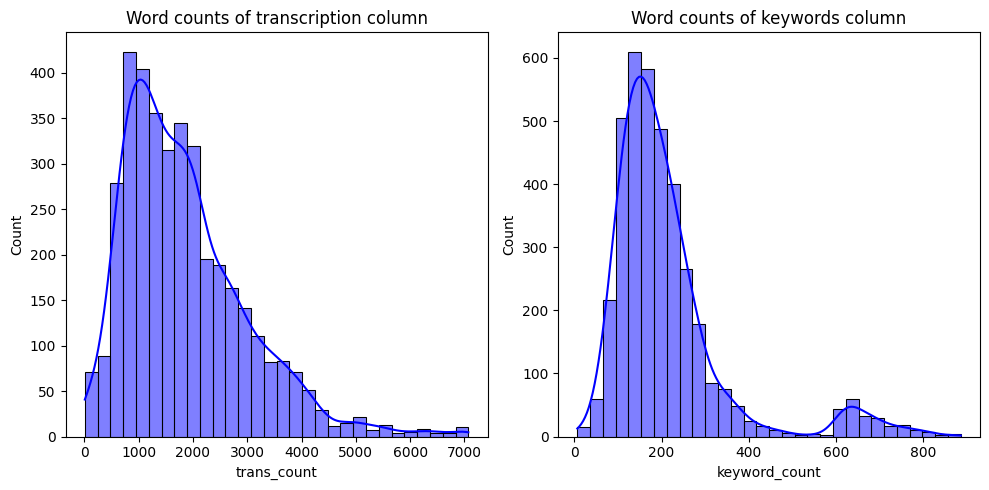

In [123]:
# Visualize the distribution of word counts
count_df = pd.DataFrame()

count_df['trans_count'] = df['transcription'].apply(lambda x: len(x))
count_df['keyword_count'] = df['keywords'].apply(lambda x: len(x))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

sns.histplot(data=count_df, x="trans_count", ax=axes[0], bins=30, kde=True, color='blue')
axes[0].set_title('Word counts of transcription column')

sns.histplot(data=count_df, x="keyword_count", ax=axes[1], bins=30, kde=True, color='blue')
axes[1].set_title('Word counts of keywords column')

plt.tight_layout()  # Adjusts spacing to prevent overlap
plt.show()

### Select the maximum sequence length for both `transcription` and `keywords`

In [124]:
# Fix the maximum length of the transcript
# Fix the maximum keywords length

max_len_transcript = 250
max_len_keywords = 30

**Exercise 7: Add `'start'` and `'end'` to `keywords` text at the beginning and end respectively [0.5 Mark]**

- 'start' will represent the beginning of output sequence
- 'end' will represent the end of output sequence

In [125]:
# Add 'start' and 'end' to keywords text

df['keywords'] = df['keywords'].apply(lambda x: '[start] ' + x + ' [end]')
df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,subjective yearold white female presents complaint allergies used allergies lived seattle thinks worse past tried claritin zyrtec worked short time seemed lose effectiveness used allegra also used...,[start] allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic [end]
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,past medical history difficulty climbing stairs difficulty airline seats tying shoes used public seating lifting objects floor exercises three times week home cardio difficulty walking two blocks ...,[start] bariatrics laparoscopic gastric bypass weight loss programs gastric bypass atkins diet weight watchers body weight laparoscopic gastric weight loss pounds months weight laparoscopic band l...


### Split data into training and testing set

- test_size=0.1
- random_state=0
- shuffle=True

In [126]:
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=0)

print(f"No. of records in training set: {len(train_df)} \n\nNo. of records in test set: {len(test_df)}")

No. of records in training set: 3435 

No. of records in test set: 382


In [127]:
train_df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
4457,Dietary consultation for a woman with polycystic ovarian syndrome and hyperlipidemia.,Consult - History and Phy.,Dietary Consultation - 1,subjective followup dietary consultation polycystic ovarian syndrome hyperlipidemia patient reports resumed food record keeping feels like given greater control physical activity level remained hi...,[start] consult history and phy dietary consultation calorie count calorie points consultation food choices food record hyperlipidemia lowfat cheese many fruits and vegetables physical activity po...
3015,"Patient with left renal cell carcinoma, left renal cyst, had robotic-Assisted laparoscopic left renal cyst decortication and cystoscopy.",Nephrology,Discharge Summary - Nephrology,admitting diagnoses left renal cell carcinoma left renal cystdischarge diagnosis left renal cell carcinoma left renal cystsecondary diagnoses chronic obstructive pulmonary disease coronary artery ...,[start] nephrology decortication cystoscopy pain nausea vomiting renal cyst decortication renal cell carcinoma robotic assisted renal cyst renal robotic laparoscopic nephrectomy cysts cell carcino...


### Tokenization and padding

**Exercise 8: Convert the `transcription` and `keywords` text to sequence of integer values, and make them of uniform length [0.5 Mark]**

- Use two tokenizers to tokenize transcription and keywords separately
  
  **Hint:** [Tokenizer()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer), `.fit_on_texts()`, `.texts_to_sequences()`

- Pad/Truncate both sequences as per their max sequence length specified in above exercises
    - use padding='post', truncating='post'
    - for transcription, (use maxlen= max_len_transcript)
    - for keywords, (use maxlen= max_len_keywords + 1)

  **Hint:** [`pad_sequences(`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)`sequences= , maxlen= , padding='post', truncating='post')`

- For long keywords sequences, the 'end' token might get truncated
    - replace the last token with the token index of 'end'

- save the vocab size for both sequences

In [140]:
# Instantiate tokenizer for transcripts
x_tokenizer = Tokenizer()

# Fit on training data
x_tokenizer.fit_on_texts(train_df['transcription'].tolist())

# Convert transcript sequences into integer sequences for both train and val set
transcript_seq = x_tokenizer.texts_to_sequences(train_df['transcription'].tolist())
test_seq = x_tokenizer.texts_to_sequences(test_df['transcription'].tolist())

# Add zero padding upto maximum length
transcript_seq = pad_sequences(transcript_seq, maxlen= max_len_transcript, padding='post', truncating='post')
test_seq = pad_sequences(test_seq, maxlen= max_len_transcript, padding='post', truncating='post')

# x vocab size
x_voc_size = len(x_tokenizer.word_index)+1
x_voc_size

26881

In [141]:
# Instantiate tokenizer for keywords
y_tokenizer = Tokenizer()

# Fit on training data
y_tokenizer.fit_on_texts(train_df['keywords'].tolist())


# Convert keywords sequences into integer sequences for train and val set
keywords_seq_train = y_tokenizer.texts_to_sequences(train_df['keywords'].tolist())
keywords_seq_test = y_tokenizer.texts_to_sequences(test_df['keywords'].tolist())

# Add zero padding upto maximum length
keywords_seq_train = pad_sequences(keywords_seq_train, maxlen= max_len_keywords+1, padding='post', truncating='post')
keywords_seq_test = pad_sequences(keywords_seq_test, maxlen= max_len_keywords+1, padding='post', truncating='post')

# y vocab size
y_voc_size = len(y_tokenizer.word_index)+1
y_voc_size

5918

In [134]:
type(keywords_seq_test)

numpy.ndarray

In [135]:
keywords_seq_test.shape

(382, 31)

- **For long keywords sequences, replace the last token with the token index of 'end'**

In [136]:
print(y_tokenizer.word_index['end'])

1


In [142]:
transcript_seq.shape

(3435, 250)

In [144]:
# Replace the last token with the token index of 'end' for long sequences

def replace_last_token_with_end(sequences, max_len, end_token_index):
    modified_sequences = []
    for seq in sequences:
        if seq[max_len - 1] != end_token_index:
            seq[max_len - 1] = end_token_index
        modified_sequences.append(seq)
    return list(np.array(modified_sequences))

# Apply on Train keywords set
keywords_seq_train = replace_last_token_with_end(keywords_seq_train, 30+1, y_tokenizer.word_index['end'])

# Apply on Validation keywords set
keywords_seq_test =  replace_last_token_with_end(keywords_seq_test, 30+1, y_tokenizer.word_index['end'])

### Positional Embedding

**Exercise 9: Create a class, `PositionalEmbedding` [1 Mark]**

- Use `mask_zero=True`, while defining token embeddings layer

- Make sure to make this layer a mask-generating layer by adding a method `compute_mask()`

In [162]:
class PositionalEmbedding(layers.Layer):

    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
      # input_dim = (token) vocabulary size,  output_dim = embedding size
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(       # Q: what is input_dim and output_dim? A: vocab size, embedding dim
            input_dim=input_dim, output_dim=output_dim, mask_zero=True)
        self.position_embeddings = layers.Embedding(    # Q: Why input_dim = seq_length?  A: there are seq_len (here 250) no. of possible positions
            input_dim=sequence_length, output_dim=output_dim, mask_zero=True)   # Q: What is the vocab for this Embedding layer ? A: seq_length
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]     # length will just be sequence length
        positions = tf.range(start=0, limit=length, delta=1) # indices for input to positional embedding
        embedded_tokens = tf.reshape(self.token_embeddings(inputs), (-1, length, self.output_dim))
        embedded_positions = tf.reshape(self.position_embeddings(positions), (-1, length, self.output_dim))
        return layers.Add()([embedded_tokens, embedded_positions])

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        return tf.math.not_equal(inputs, 0)     # mask will get propagated to the next layer.

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

### Encoder Block

**Exercise 10: Create a class, `TransformerEncoder` [1 Mark]**

- While calling `attention` layer, do not use `attention_mask` parameter

- In Feed forward network, add `Dropout(0.1)` layer after 2 dense layers

- For skip connections, use `tf.keras.layers.Add()` instead of `'+'`

In [163]:
class TransformerEncoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate, **kwargs):

        super().__init__(**kwargs)
        self.embed_dim = embed_dim    # Dimension of embedding. 4 in the dummy example
        self.dense_dim = dense_dim    # No. of neurons in dense layer
        self.num_heads = num_heads    # No. of heads for MultiHead Attention layer
        self.dropout_rate = dropout_rate
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)    # MultiHead Attention layer
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),]    # encoders are stacked on top of the other.
                                           )                             # So output dimension is also embed_dim
        self.dropout = layers.Dropout(dropout_rate)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # if mask is not None:
        #     mask = mask[:, tf.newaxis, :]
        #     print(f"**test: mask in not None. mask = {mask}")

        attention_output = self.attention(query=inputs,             # Query: inputs,
                                          value=inputs,             # Value: inputs,
                                          key=inputs,               # Keys: Same as Values by default
                                        #   attention_mask=mask
                                          )                         # Q: Can you see how this is self attention? A: all args are the same

        proj_input = self.layernorm_1(layers.Add()([inputs, attention_output])) # LayerNormalization; + Recall cat picture
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dropout(proj_output)
        return self.layernorm_2(layers.Add()([proj_input, proj_output]))  # LayerNormalization + Residual connection


    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### Decoder Block

**Exercise 11: Create a class, `TransformerDecoder` [1 Mark]**

- Do not create any separate function to get causal attention mask, just pass `use_causal_mask = True` parameter while calling `attention_1` layer

- While calling `attention_2` layer, do not use `attention_mask` parameter

- In Feed forward network, add `Dropout(0.1)` layer after 2 dense layers

- For skip connections, use `tf.keras.layers.Add()` instead of `'+'`

In [164]:
class TransformerDecoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate, **kwargs):
         # Define the layers. Let's point them out in the diagram
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        # Now we have 2 MultiHead Attention layers - one for self attention and one for generalized attention
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),]
                                           )
        self.dropout = layers.Dropout(dropout_rate)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True   #ensures that the layer will propagate its input mask to its outputs;

    def get_config(self):

        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def call(self, inputs, encoder_outputs, mask=None): # two inputs: decoder i/p and encoder o/p

        attention_output_1 = self.attention_1(query=inputs,                     # Q: What kind of attention?  A: self attention
                                              value=inputs,
                                              key=inputs,
                                              use_causal_mask=True       # Q: What will the causal_mask do? A: makes attention score of a query independent of future tokens
                                              )

        attention_output_1 = self.layernorm_1(layers.Add()([inputs, attention_output_1]))

        attention_output_2 = self.attention_2(query=attention_output_1,         # Q: Is this self attention? A: No. This is generalised attention
                                              value=encoder_outputs,            # Key and Value coming from encoder
                                              key=encoder_outputs
                                              )

        attention_output_2 = self.layernorm_2(layers.Add()([attention_output_1, attention_output_2]))
        proj_output = self.dense_proj(attention_output_2)
        proj_output = self.dropout(proj_output)
        return self.layernorm_3(layers.Add()([attention_output_2, proj_output]))


### Build Transformer model

**Exercise 12: Create a transformer model with below points: [1 Mark]**

- Use the respective vocabulary size for PositionalEmbedding of encode and decoder inputs

- Add `Dropout(0.1)` layers after both encoder and decoder PositionalEmbedding layers

- Do not use `activation="softmax"` for the last dense classification layer (You will be required to create a custom loss, and metric in the next stage.)

- Add a stack of 4 encoder blocks and 4 decoder blocks to your transformer

In [165]:
# Create transformer model
embed_dim = 256
dense_dim = 2048
num_heads = 8
dropout_rate = 0.1
num_enc = 4
num_dec = 4
## Encoder

encoder_inputs = keras.Input(shape=(None,))

x = PositionalEmbedding(max_len_transcript, x_voc_size, embed_dim)(encoder_inputs) # Q: First arg acts like a 'vocabulary' for pos embedding layer
x = layers.Dropout(0.1)(x)

encoder_blocks = [TransformerEncoder(embed_dim, dense_dim, num_heads, dropout_rate) for i in range(num_enc)]
enc_input = x
for encoder_block in encoder_blocks:

    encoder_output = encoder_block(enc_input)
    enc_input = encoder_output

encoder_outputs = encoder_output

## Decoder
decoder_inputs = keras.Input(shape=(None,))

y = PositionalEmbedding(max_len_keywords, y_voc_size, embed_dim)(decoder_inputs)
y = layers.Dropout(0.1)(y)

decoder_blocks = [TransformerDecoder(embed_dim, dense_dim, num_heads, dropout_rate) for i in range(num_dec)]
dec_input = y

for decoder_block in decoder_blocks:

    decoder_output = decoder_block(dec_input, encoder_outputs)
    dec_input = decoder_output
decoder_outputs = decoder_output
decoder_outputs = layers.Dense(y_voc_size)(decoder_outputs)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_8    │ (None, None, 256)      │      6,945,536 │ input_layer_40[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_88 (Dropout)      │ (None, None, 256)      │              0 │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_16    │ (None, None, 256)      │      3,155,456 │ dropout_88[0][0]       │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_45            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_17    │ (None, None, 256)      │      3,155,456 │ transformer_encoder_1… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_9    │ (None, None, 256)      │      1,522,688 │ input_layer_45[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_18    │ (None, None, 256)      │      3,155,456 │ transformer_encoder_1… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_97 (Dropout)      │ (None, None, 256)      │              0 │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_19    │ (None, None, 256)      │      3,155,456 │ transformer_encoder_1… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_16    │ (None, None, 256)      │      5,259,520 │ dropout_97[0][0],      │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_17    │ (None, None, 256)      │      5,259,520 │ transformer_decoder_1… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_18    │ (None, None, 256)      │      5,259,520 │ transformer_decoder_1… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_19    │ (None, None, 256)      │      5,259,520 │ transformer_decoder_1… │
│ (TransformerDecoder) 

 Total params: 43,649,054 (166.51 MB)

 Trainable params: 43,649,054 (166.51 MB)

 Non-trainable params: 0 (0.00 B)

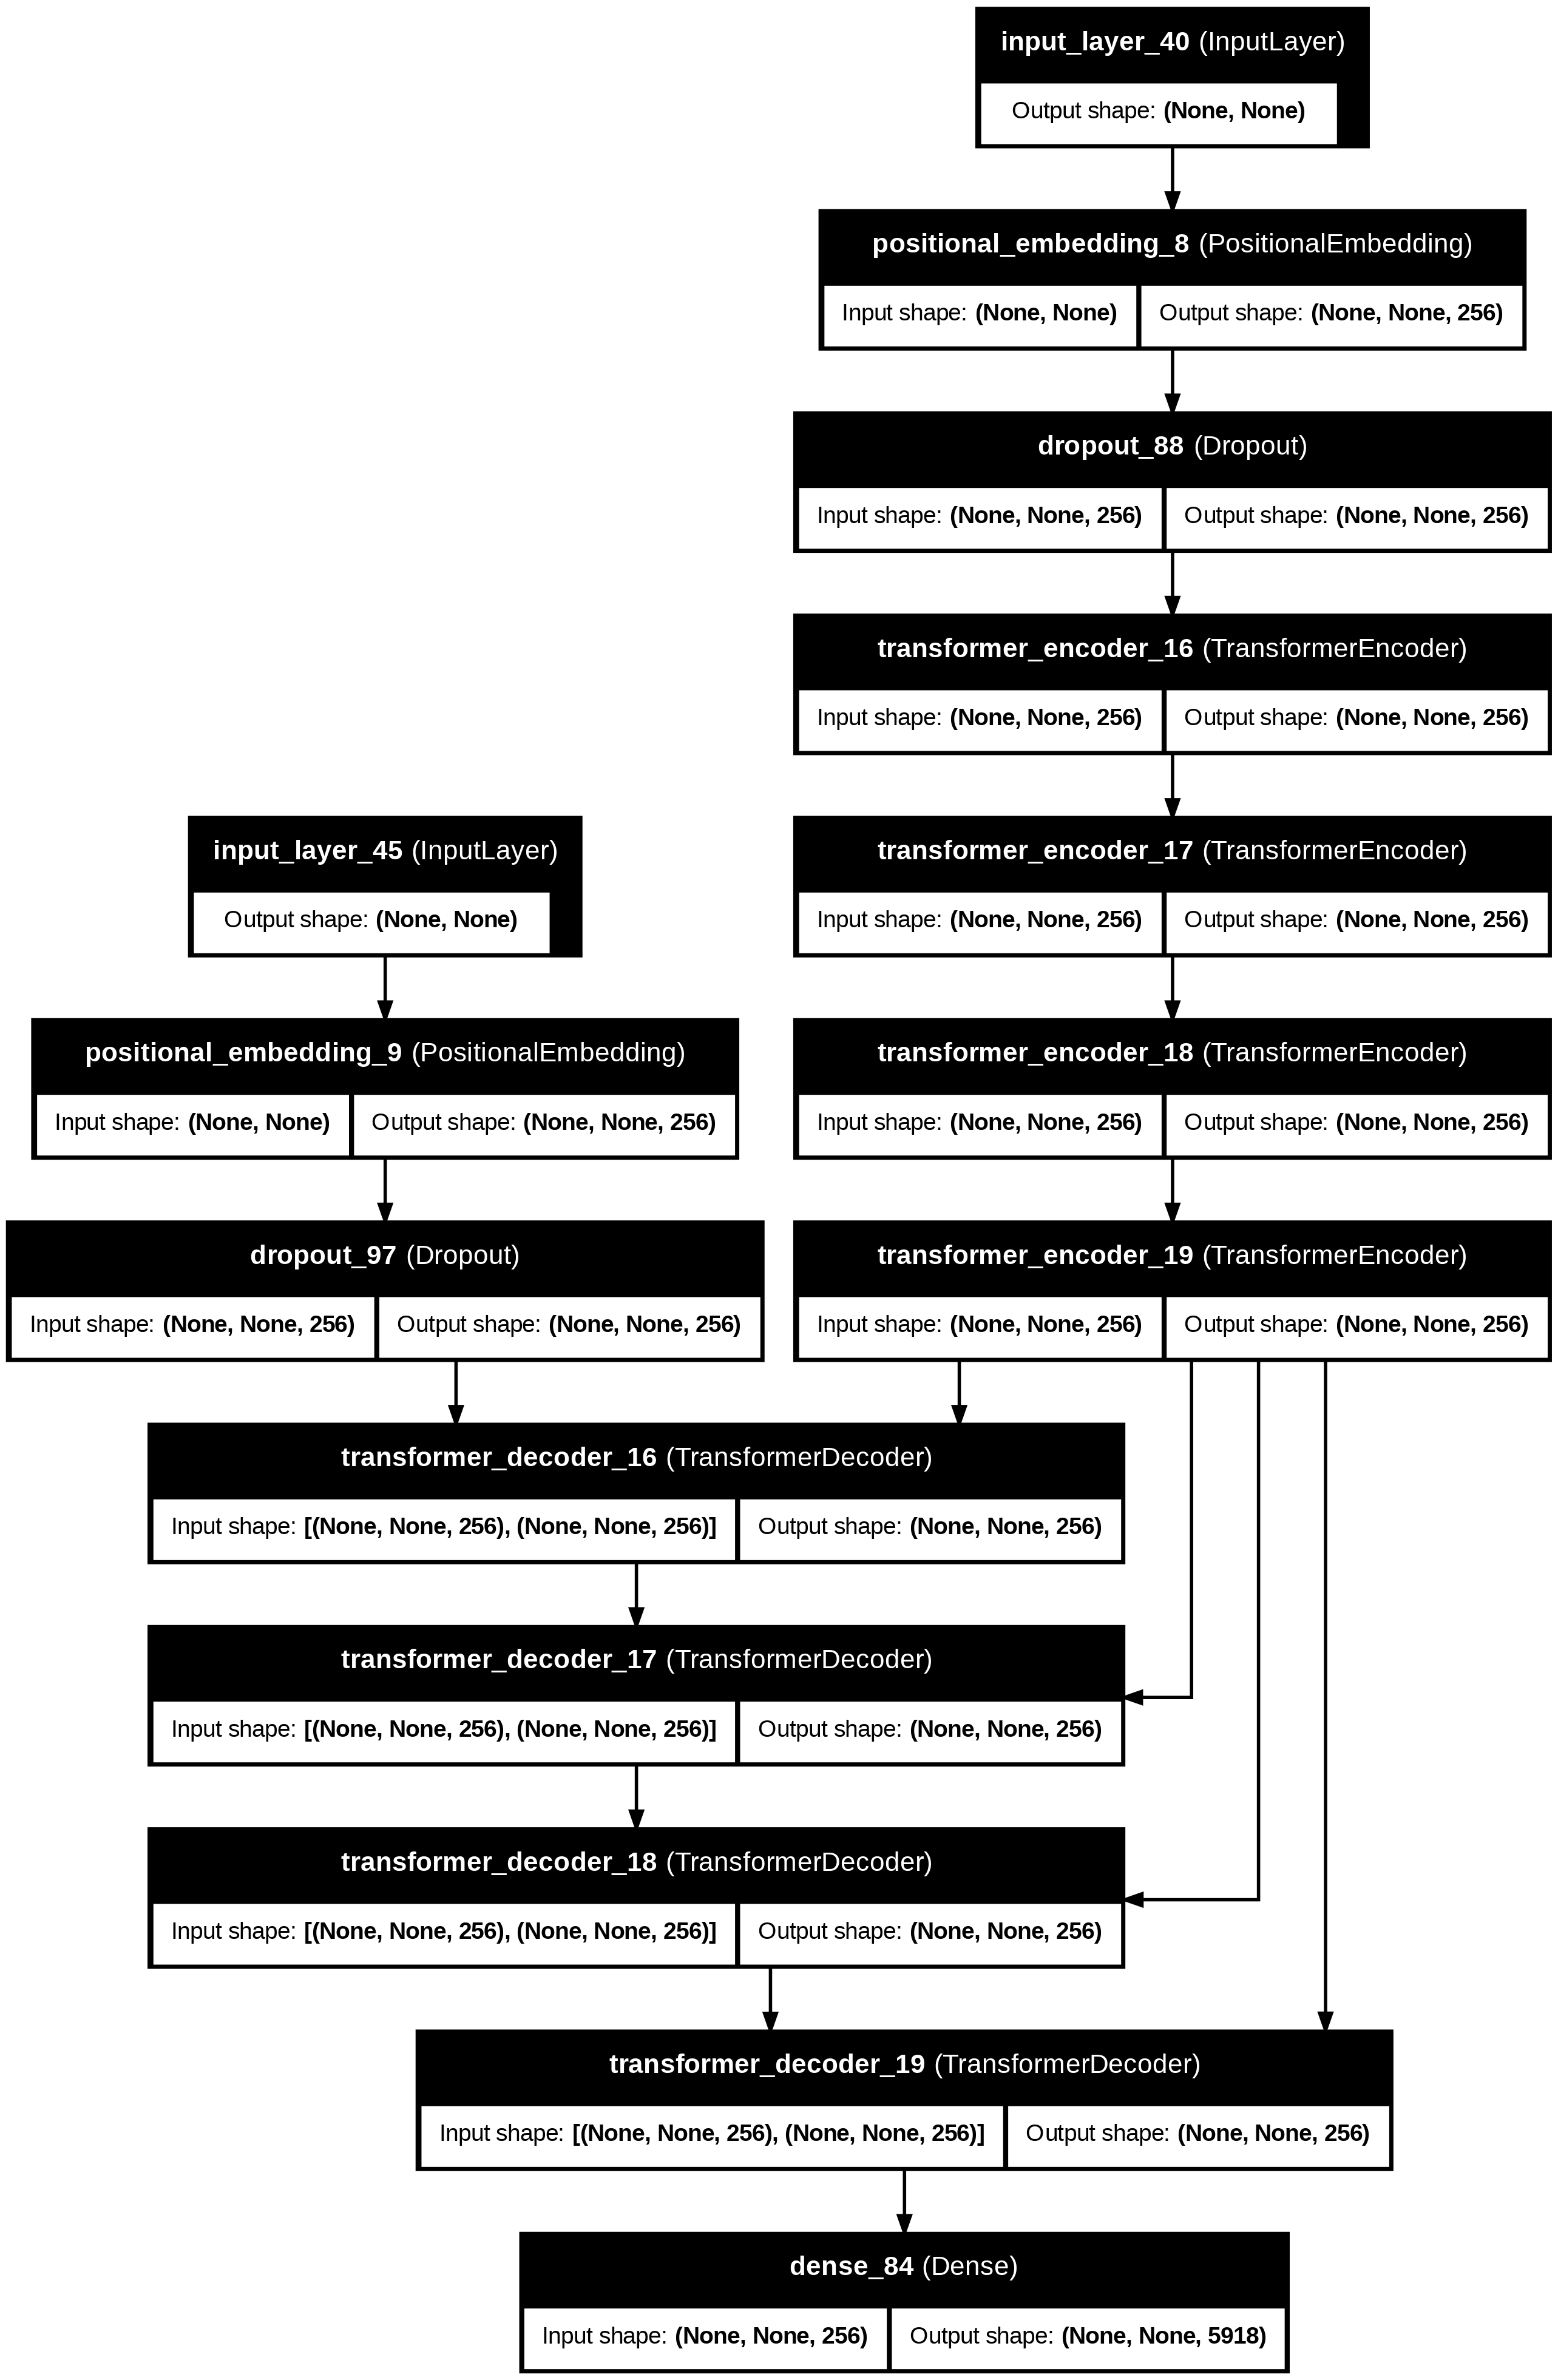

In [166]:
from tensorflow.keras.utils import plot_model

# Assuming 'transformer' is your model
plot_model(transformer,
           show_shapes=True,                   # Show the shapes of the tensors
           show_layer_names=True)          # Show the layer names
        #    rankdir='TD')

In [167]:
print(f"Token embedding weights for transcripts: {embed_dim*x_voc_size}")
print(f"Position embedding weights for transcripts: {embed_dim*max_len_transcript}")
print(f"Total no. of weights: {embed_dim*x_voc_size + embed_dim*max_len_transcript}")

Token embedding weights for transcripts: 6881536
Position embedding weights for transcripts: 64000
Total no. of weights: 6945536


## Model Compilation and Training [1 Mark]

**Exercise 13: Set up the optimizer**

Refer [here](https://www.tensorflow.org/text/tutorials/transformer#set_up_the_optimizer) for the following steps:

- Use the Adam optimizer with a custom learning rate scheduler

- Instantiate the Adam optimizer with custom learning rate

In [168]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [169]:
# Instantiate the Adam optimizer with custom learning rate
learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

**Exercise 14: Set up the loss and metrics**

- Apply a padding mask while calculating the loss with cross-entropy loss function as demonstrated [here](https://www.tensorflow.org/text/tutorials/transformer#set_up_the_loss_and_metrics).  

In [170]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

**Exercise 15: Compile transformer model with custom optimizer, loss, and metric & perform training [0.5 Mark]**

- Use [*transcription sequences*, and *keywords sequences(shifted right)*] as input to transformer

- Train model using colab's GPU runtime with batch_size=32, and epochs=30. (It might take one minute per epoch with GPU)

**Hint:** Check if the training code is running without any errors with CPU runtime, later switch to GPU runtime for faster training. Once trained, save the model weights, and download into your system for later use.

In [171]:
# Compile
transformer.compile(optimizer=optimizer,
                    loss=masked_loss,
                    metrics=[masked_accuracy]
                    )

In [172]:
train_df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
4457,Dietary consultation for a woman with polycystic ovarian syndrome and hyperlipidemia.,Consult - History and Phy.,Dietary Consultation - 1,subjective followup dietary consultation polycystic ovarian syndrome hyperlipidemia patient reports resumed food record keeping feels like given greater control physical activity level remained hi...,[start] consult history and phy dietary consultation calorie count calorie points consultation food choices food record hyperlipidemia lowfat cheese many fruits and vegetables physical activity po...
3015,"Patient with left renal cell carcinoma, left renal cyst, had robotic-Assisted laparoscopic left renal cyst decortication and cystoscopy.",Nephrology,Discharge Summary - Nephrology,admitting diagnoses left renal cell carcinoma left renal cystdischarge diagnosis left renal cell carcinoma left renal cystsecondary diagnoses chronic obstructive pulmonary disease coronary artery ...,[start] nephrology decortication cystoscopy pain nausea vomiting renal cyst decortication renal cell carcinoma robotic assisted renal cyst renal robotic laparoscopic nephrectomy cysts cell carcino...


In [178]:
transcript_seq.shape

(3435, 250)

In [179]:
test_seq.shape

(382, 250)

In [184]:
type(transcript_seq)

numpy.ndarray

In [189]:
for i in keywords_seq_train[0:2]:
    print(i[:-1])

[   2   37   30    4   43  375  419 1216  765 1216 3225  419  462 5373
  462 5374  937 5375 5376 5377 5378    4 5379  264  621 2514  561  111
 3226  375]
[   2  316  888  301   23  353  440   26  282  888   26  194  129 1605
  738   26  282   26 1605   32  803 1792  194  129  176    1    0    0
    0    0]


In [190]:
np.array([seq[:-1] for seq in keywords_seq_train])

array([[   2,   37,   30, ...,  111, 3226,  375],
       [   2,  316,  888, ...,    0,    0,    0],
       [   2,  105,  180, ..., 2516, 1932, 3722],
       ...,
       [   2,  264,   98, ..., 1137, 1488,  806],
       [   2,  316,  783, ...,  751,   10,  118],
       [   2,  124,   98, ...,    0,    0,    0]], dtype=int32)

In [185]:
keywords_seq_train[0][:-1]

array([   2,   37,   30,    4,   43,  375,  419, 1216,  765, 1216, 3225,
        419,  462, 5373,  462, 5374,  937, 5375, 5376, 5377, 5378,    4,
       5379,  264,  621, 2514,  561,  111, 3226,  375], dtype=int32)

In [183]:
[keywords_seq_train)

3435

In [218]:
transformer.fit([transcript_seq, np.array([seq[:-1] for seq in keywords_seq_train])], np.array([seq[1:] for seq in keywords_seq_train]),
                epochs=30,
                batch_size=32,
                validation_data=([test_seq, np.array([seq[:-1] for seq in keywords_seq_test])], np.array([seq[1:] for seq in keywords_seq_test])))

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 47s 438ms/step - loss: 7.9790 - masked_accuracy: 0.0924 - val_loss: 7.5569 - val_masked_accuracy: 0.1065
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - loss: 7.3953 - masked_accuracy: 0.1126 - val_loss: 6.9980 - val_masked_accuracy: 0.1155
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 437ms/step - loss: 6.8666 - masked_accuracy: 0.1293 - val_loss: 6.4810 - val_masked_accuracy: 0.1613
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 437ms/step - loss: 6.2982 - masked_accuracy: 0.1621 - val_loss: 5.9708 - val_masked_accuracy: 0.1995
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 438ms/step - loss: 5.7382 - masked_accuracy: 0.2016 - val_loss: 5.4841 - val_masked_accuracy: 0.2391
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 46s 430ms/step - loss: 5.1524 - masked_accuracy: 0.2548 - val_loss: 5.0110 - val_masked_accuracy: 0.2694
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 84s 449ms/step - loss: 4.6048 - masked_accuracy: 0.3056 - val_loss: 4.5563 - val_masked_ac

### Save model weights

In [193]:
!mkdir my_model_weights

In [219]:
# Save model weights
# It will create a '.weights.h5' file which can be downloaded into your system from colab

transformer.save_weights('my_model_weights/my_weights.weights.h5')

In [227]:
# OR
# Make a zip file, which also can be downloaded into your system from colab

!zip -r 'my_model_weights.zip' 'my_model_weights'

  adding: my_model_weights/ (stored 0%)
  adding: my_model_weights/my_weights.weights.h5 (deflated 9%)
  adding: my_model_weights/.ipynb_checkpoints/ (stored 0%)


### Load model weights

Whenever you need to use this trained model weights:
* use the model architecture to create exact same model
* then load the trained weights directly using below code

In [220]:
# To load model weights
transformer.load_weights('my_model_weights/my_weights.weights.h5')

## Run Inference

**Exercise 16: Create a function to extract keywords, given transcription text as input [1 Mark]**

- Encode the input sentence using the Transcription tokenizer. This is the encoder input
- Initialize decoder input with the 'start' token
- The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
- Concatenate the predicted token to the decoder input and pass it to the decoder repeatedly
- Make decoder predict the next token based on the previous tokens it has predicted

In [221]:
def extract_keywords(sentence, transformer=transformer):

    """ Takes an input sentence, and transformer. Returns extracted keywords. """

    # Convert input sentence into integer sequence (Note that tokenizer.texts_to_sequences() take list of text as input)
    ip_tokens = x_tokenizer.texts_to_sequences([sentence])
    # print(ip_tokens)
    # print(len(ip_tokens))

    # Add zero padding upto maximum length transcription
    ip_tok_seq = pad_sequences(ip_tokens, maxlen= max_len_transcript, padding='post', truncating='post')
    # print(ip_tok_seq)
    # print(len(ip_tok_seq))
    # print(ip_tok_seq.reshape(1,-1))

    # Create a decoder sequence with 'start' token index
    dec_tok_seq = np.array([y_tokenizer.word_index['start']])
    # print(dec_tok_seq)
    # print(dec_tok_seq.reshape(1, -1))

    # Variable to store the output text string
    keyword_sentence = ''

    for i in range(max_len_keywords):

        # Get output logits from transformer
        pred = transformer([ip_tok_seq.reshape(1,-1), dec_tok_seq.reshape(1, -1)], training=False)
        pred = pred[:, -1:, :]

        # Select the index with max value from 'pred' to get the output token index
        token_id = np.argmax(pred, axis=-1)
        # token_id = pred.index(max(pred))
        # print(token_id)
        # print(token_id[0][0])

        # Convert output token to word
        # print(y_tokenizer.index_word[token_id[0][0]])
        word = y_tokenizer.index_word[token_id[0][0]]

        # End the loop if word is 'end'
        if word == 'end':
            break

        # Append 'token' to dec_tok_seq
        dec_tok_seq = np.append(dec_tok_seq, token_id)

        # Append 'word' to keyword sentence
        keyword_sentence += " " + word

    return keyword_sentence.strip()

In [222]:
sent = 'He has been experiencing headaches that have been getting worse over the past two months. The headaches are accompanied by lightheadedness, nausea, vomiting, and sensitivity to light and sound. He complains of epigastric pain that feels like burning, about twice a month, mainly at night. He has aching lower back pain, about once a week after gardening. The pain usually goes away after taking Tylenol.'
len(sent)

403

In [223]:
extract_keywords(sent, transformer)

'consult history and phy visual acuity blurred vision tinnitus headaches residual disease weight loss fevers tumor examination pancreatic ct weight loss shoulder'

## Gradio Implementation [OPTIONAL]

Gradio is an open-source python library that allows us to quickly create easy-to-use, customizable UI components for our ML model, any API, or any arbitrary function in just a few lines of code. We can integrate the GUI directly into the Python notebook, or we can share the link with anyone.

In [224]:
!pip -qq install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.0 MB/s eta 0:00:00


In [225]:
import gradio

In [226]:
# Input from user
in_transcript = gradio.Textbox(lines=10, placeholder=None, value="transcription", label='Enter Transcription Text')

# Output prediction
out_keywords = gradio.Textbox(type="text", label='Extracted Keywords')


# Gradio interface to generate UI
iface = gradio.Interface(fn = extract_keywords,
                         inputs = [in_transcript],
                         outputs = [out_keywords],
                         title = "Keywords Extraction",
                         description = "Using transformer model, trained from scratch",
                         allow_flagging = 'never')

iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b7648e056b65b281da.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Click on the link generated above to see UI.